In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import math
from printTable import printTable # helper function

In [2]:
# parse json file to features - phillip
data_file_name = '../data/data_train.json'
nPoints = 21
with open(data_file_name) as json_file:
    data = json.load(json_file)
    
    # matrix to store distance to keypoint 0, each image stored in row
    # column array to store labels

    distance_feature = np.ones((int(data["num_pics"]), nPoints-1))
    label_vector = np.ones((int(data["num_pics"]),1))
    
    # loop through json to constuct feature array
    for i in range(1, int(data["num_pics"])+1): # use num_pics+1 because range ends at integer before stop value
        label = data["pics"][str(i)]["label"] 
        points = np.array(data["pics"][str(i)]["keypoints"] )
        
        # label array
        label_vector[i-1] = label
        # feature matrix
        pointZero = points[0] # reference distance from point 0
        for j in range(1,nPoints): # calculate distances for points 1-20
            distance_feature[i-1][j-1] = math.sqrt(np.sum(np.square(points[j] - pointZero)))
        
#     print(distance_feature)
#     print(label_vector)

## Single Class SVM

In [3]:
# get data
X = distance_feature
b = label_vector

# model parameters
num_samples = len(b)
X_svm = np.hstack((X, np.ones((num_samples, 1))))
num_features = len(X[0])
w_k = np.zeros((num_features+1, 1))

r = 10 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize

# loop through each class
classes = [0,1,2,3,4,5]
b_classes = np.zeros((len(b),len(classes)))
b_test_svm = np.zeros(b_classes.shape)
b_test_ls = np.zeros(b_classes.shape)
w_svm = np.zeros((len(w_k),len(classes)))
w_ls = np.zeros((len(w_k),len(classes)))

for c in classes:
    # form binary labels
    b_svm = np.where(b == c, 1, -1)
    b_classes[:,c] = b_svm.reshape(len(b_svm))
    
    # train svm
    num_steps = 5000
    counter = 0
    counter2 = 0
    for i in range(num_steps):
        # loop through training samples
        l_hinge = np.zeros(w_k.shape)
        for s in range(num_samples):
            # indicator function
            counter2 +=1
            if b_svm[s]*X_svm[s]@w_k <= 1:
                counter +=1
                l_hinge = np.add(l_hinge, -b_svm[s]*X_svm[s].reshape(l_hinge.shape))
#         w_k = w_k - tau*(l_hinge+2*r*w_k)
        w_tilda = np.copy(w_k)
        w_tilda[-1] = 0
        w_k = w_k - tau*(l_hinge+2*r*w_tilda)
        
    # save weights
    w_svm[:,c] = w_k.reshape(len(w_k)) # svm
    w_k_ls = np.linalg.inv(X_svm.T@X_svm)@X_svm.T@b_svm # least squares
    w_ls[:,c] = w_k_ls.reshape(len(w_k_ls))
#     print("Weights for class {}:".format(c))
#     print(w_k)

# test svm against known training data
header = ["class", "svm error", "least squares error"]
data = []
for c in classes:
    b_hat_svm = X_svm@w_svm[:,c]
    b_hat_ls = X_svm@w_ls[:,c]
    b_test_svm[:,c] = b_hat_svm.reshape(len(b))
    b_test_ls[:,c] = b_hat_ls.reshape(len(b))

    # find percent incorrect
    num_incorrect_ls = np.sum(np.sign(b_test_ls[:,c]) != b_classes[:,c])
    percent_incorrect_ls = num_incorrect_ls/len(b)*100
    num_incorrect_svm = np.sum(np.sign(b_test_svm[:,c]) != b_classes[:,c])
    percent_incorrect_svm = num_incorrect_svm/len(b)*100
    data.append([c,"{:0.2f} %".format(percent_incorrect_svm), "{:0.2f} %".format(percent_incorrect_ls)])

# print table
printTable(header,data)

| class | svm error | least squares error | 
| ----- | --------- | ------------------- | 
|   0   |   0.00 %  |        0.00 %       | 
|   1   |   0.00 %  |        0.55 %       | 
|   2   |   3.87 %  |        4.42 %       | 
|   3   |   1.66 %  |        6.63 %       | 
|   4   |   0.55 %  |        2.76 %       | 
|   5   |   1.10 %  |        3.87 %       | 


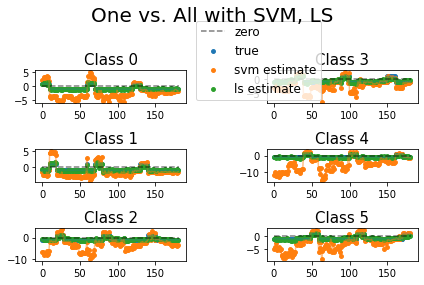

In [4]:
# plot
fig,ax = plt.subplots(3,2)
plt.rcParams['figure.figsize'] = [20, 10] # matplotlib window size = [width, height]

for c in classes:
    if c < 3:
        count2 = 0
    else:
        count2 = 1
    ax[c%3][count2].set_title("Class {}".format(c),fontsize=15)
    ax[c%3][count2].scatter(range(len(b_classes[:,c])), b_classes[:,c], label="true", color="C0", s=15)
    ax[c%3][count2].plot(range(len(b_classes[:,c])), b_classes[:,c], alpha=0.5, color="C0")
    ax[c%3][count2].scatter(range(len(b_classes[:,c])), b_test_svm[:,c], label="svm estimate", color="C1", s=15)
    ax[c%3][count2].plot(range(len(b_classes[:,c])), b_test_svm[:,c], alpha=0.5, color="C1")
    ax[c%3][count2].scatter(range(len(b_classes[:,c])), b_test_ls[:,c], label="ls estimate", color="C2", s=15)
    ax[c%3][count2].plot(range(len(b_classes[:,c])), b_test_ls[:,c], alpha=0.5, color="C2")
    ax[c%3][count2].plot([0,len(b_classes[:,c])], [0,0], alpha=0.5, linestyle="--", color="k", label="zero")

ax[0][1].legend(bbox_to_anchor=(0.4, 1.3), loc='right', ncol=1,fontsize=12) # legend
title = fig.suptitle("One vs. All with SVM, LS",fontsize=20) # title
fig.tight_layout() # prevent overlapping
plt.show()

In [5]:
# TODO: implement for predicting new test data

In [6]:
# model parameters
X_svm = np.hstack((X, np.ones((len(b), 1))))
w_k = np.zeros((len(X[0])+1, 1))

r = 0 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize

# loop through each class
classes = [0,1,2,3,4,5]
w_svm = np.zeros((len(w_k),len(classes)))
weights_classes = []
descent_done = False

#x0 = np.where(b == 0)
#x1 = np.where(b == 1)
#x2 = np.where(b == 2)
#x3 = np.where(b == 3)
#x4 = np.where(b == 4)
#x5 = np.where(b == 5)
    
for i in range(len(classes)):
    for j in range(len(classes)):
        if j>i:
            print(i,j)
            #create test groups
            g1 = np.where(b == i)[0]
            g2 = np.where(b == j)[0]
            w_k = np.zeros((len(X[0])+1, 1))

            X_class1 = [X_svm[k] for k in g1]
            X_class2 = [X_svm[k] for k in g2]
            X_class = np.vstack((X_class1,X_class2))
            b_class_orig1 = [b[k] for k in g1]
            b_class_orig2 = [b[k] for k in g2]
            b_class_orig = b_class_orig1 + b_class_orig2
            b_svm = np.where(np.asarray(b_class_orig) == i, 1, -1)

            # train svm
            last_loss = 100000000000000.
            descent_done = False
            iterations = 0

            while not descent_done:
                loss = 0
                # loop through training samples
                l_hinge = np.zeros(w_k.shape)
                
                for s in range(len(b_svm)):
                    # indicator function
                    if b_svm[s]*X_class[s]@w_k <= 1:
                        loss += (1-b_svm[s]*X_class[s]@w_k)
                        l_hinge = np.add(l_hinge, -b_svm[s]*X_class[s].reshape(l_hinge.shape))
    
                # compare loss to determine if reached minimum
                if(last_loss < loss):
                    print(loss)
                    print("Class {} converged after {} iterations:".format(c,iterations))
                    descent_done = True
                else:
                    # svm weights
                    w_tilda = np.copy(w_k)
                    w_tilda[-1] = 0
                    w_k = w_k - tau*(l_hinge+2*r*w_tilda)

                # update for next iteration
                last_loss = loss
                iterations +=1

            # save weights
            weights_classes.append(w_k.reshape(len(w_k))) # svm
            
            # Graph
            #fig = plt.figure()
            #plt.plot(X[(i!=b),0],X[(i!=b),1],'.', color = 'w')
            #plt.plot(X[(i==b),0],X[(i==b),1],'.', color = 'r', label = '+1 label')
            #plt.plot(X[(j==b),0],X[(j==b),1],'.', color = 'grey', label = '-1 label')
        
            #plt.xlabel('x')
            #plt.ylabel('y')
            #plt.title('OvO with Class %s = +1, Class %d = -1'%(i,j))
            
            # plot decision boundary
            #plot_bounds = [0.5, 6.5]
            #plot_svm(w_k, plot_bounds) # helper function
            #plt.show()
            
print("Training complete!")

0 1
[1.76833096]
Class 5 converged after 1859 iterations:
0 2
[0.30341948]
Class 5 converged after 1118 iterations:
0 3
[0.31852829]
Class 5 converged after 1320 iterations:
0 4
[0.33155131]
Class 5 converged after 678 iterations:
0 5
[0.28876253]
Class 5 converged after 954 iterations:
1 2
[1.02157118]
Class 5 converged after 1260 iterations:
1 3
[1.57145415]
Class 5 converged after 1095 iterations:
1 4
[0.34376341]
Class 5 converged after 736 iterations:
1 5
[0.74989732]
Class 5 converged after 535 iterations:
2 3
[21.21127913]
Class 5 converged after 773 iterations:
2 4
[0.67827412]
Class 5 converged after 1125 iterations:
2 5
[3.47974139]
Class 5 converged after 415 iterations:
3 4
[1.52058858]
Class 5 converged after 754 iterations:
3 5
[1.38075269]
Class 5 converged after 1196 iterations:
4 5
[11.99082216]
Class 5 converged after 995 iterations:
Training complete!


In [7]:
# test svm against known training data
header = ["class", "  svm  "]
data = []
count_class = np.zeros((6))
count_total = np.zeros((6))
b_test_svm = []

c1 = 0
c2 = 1
#print(data_testing[0])
num_wrong = 0
counter = 0
a = 0
for x in X_svm: 
    count_class = [0,0,0,0,0,0]
    counter +=1
    for w in range(len(weights_classes)):
        #print(x)
        #print(weights_classes[w])
        b_hat_svm = x@weights_classes[w]
        
        #if a == 0:
        #    print(c1,c2)
        #    print(count_class)
        
        if b_hat_svm > 0:
            count_class[c1] = count_class[c1] + 1
        elif b_hat_svm < 0:
            count_class[c2] = count_class[c2] + 1
        if c2<len(classes) - 1:
            c2 = c2 + 1
        else:
            c1 = c1 + 1
            c2 = c1 + 1
    
    
    #print(count_class)
    c1 = 0
    c2 = 1
    b_test_svm.append(classes[np.argmax(count_class)])
#print(b_test_svm)
#print(b_classes)
    count_total = count_total + count_class

count_wrong = np.zeros((6))
count_total = np.zeros((6))
error_total = np.zeros((6))
for m in range(len(b)):
    if b[m] != b_test_svm[m]:
        count_wrong[int(b[m][0])] += 1
        num_wrong = num_wrong+1
    count_total[int(b[m][0])] =  count_total[int(b[m][0])] + 1
    
# find percent incorrect
#num_incorrect_svm = np.sum(np.sign(b_test_svm[:,w]) != b_classes[:,w])
percent_incorrect_svm = num_wrong/len(b)*100

#print(count_total)
#print(count_wrong)

error_total = np.divide(count_wrong,count_total)
print("error", error_total)

data.append(["OvO","{:0.2f} %".format(percent_incorrect_svm)])
#print(percent_incorrect_svm)
printTable(header,data)

error [0.         0.         0.16666667 0.03225806 0.         0.        ]
| class |   svm   | 
| ----- | ------- | 
|  OvO  |  3.31 % | 
